In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
import copy
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve ,precision_recall_curve,log_loss,average_precision_score
from sklearn.metrics import f1_score
import random
import gc

%matplotlib inline

In [2]:
#df = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/test.csv'))
df_sortprob = pd.read_csv('df_sortprob_23_no_test.csv')
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [4]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')       
        print("'"+nm+"'",', ',end='')

In [5]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [6]:
def group_ag(main_columns, uids, train_df, test_df, aggregations=['mean'],
              fillna = True):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'__'+col+'_'+agg_type
                #拼接训练集和测试集
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])  
                #求AGG
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
                # 取出目标列作为索引
                temp_df.index = list(temp_df[col])
                # 生成map对应的字典
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-100,inplace=True)
                    test_df[new_col_name].fillna(-100,inplace=True)  
                    
                print("'"+new_col_name+"'",', ',end='')
#group_ag(['conam'],['cano'],df,df_test,['mean','std'])
#df['conam_cano_std'].value_counts()

In [7]:
def fillna(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )
    df1[col]=df1[col].fillna(-100)
    df2[col]=df2[col].fillna(-100)     
    print(df1[col].value_counts(dropna=False, normalize=True).head())     

In [8]:
def fillNY(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )   
    print(df1[col].value_counts(dropna=False, normalize=True).head())      

In [9]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')

In [10]:
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols.remove('fraud_ind')
big_top_value_cols.remove('stscd')
#big_top_value_cols.remove('iterm')
#big_top_value_cols.remove('hcefg')
#big_top_value_cols.remove('contp')
big_top_value_cols

['contp', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'ovrlt']

In [11]:
#not use label encoding
fillNY(df,df_test,'insfg')
fillNY(df,df_test,'ovrlt')
fillNY(df,df_test,'ecfg')
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')

0    0.972196
1    0.027804
Name: insfg, dtype: float64
0    0.986693
1    0.013307
Name: ovrlt, dtype: float64
0    0.745513
1    0.254487
Name: ecfg, dtype: float64
 0.0      0.988399
-100.0    0.008267
 1.0      0.003334
Name: flbmk, dtype: float64
 0.0      0.949454
 1.0      0.042279
-100.0    0.008267
Name: flg_3dsmk, dtype: float64


In [12]:
def change_time(data):
    time = data['loctm']
    hour = []
    hour_min = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        h_m=int(i/100)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        hour_min.append(h_m)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second
    data['loctm_hour_min'] = hour_min

In [13]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    #data['conam_log'] = log
    data['conam_sqrt'] = sqrt  
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [14]:
change_time(df_sortprob)
change_time(df)
change_time(df_test)
import copy
df_sortprob=df_sortprob.drop(big_top_value_cols, axis=1)
df=df.drop(big_top_value_cols, axis=1)
df_test=df_test.drop(big_top_value_cols, axis=1)
df_backup = copy.copy(df_sortprob)
df_test_backup = copy.copy(df_test)
print(df.columns)
print(df.shape)

Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s',
       'loctm_hour_min'],
      dtype='object')
(1521787, 20)


In [15]:
# PR 曲线对比
def show_pr():
        l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
        pr,re,t = precision_recall_curve(y_valid_df,pred)
        plt.figure(figsize=(8,8))
        plt.plot(l_pr,l_re,color='red',label='last best')
        plt.plot(pr,re,color='green',label="now")
        plt.legend()
        plt.show()

## 從這裡開始

In [16]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
print(df.shape[1])
print(df_test.shape[1])
print(df.columns)
print(df_test.columns)

20
19
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s',
       'loctm_hour_min'],
      dtype='object')
Index(['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'locdt',
       'loctm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd', 'txkey',
       'loctm_hour', 'loctm_min', 'loctm_s', 'loctm_hour_min'],
      dtype='object')


In [17]:
change_time(df)
change_time(df_test)

In [18]:
#新特徵
encode_CB('bacno','cano',df,df_test) 
encode_CB('mcc','mchno',df,df_test)
encode_CB('stocn','scity',df,df_test)
encode_CB('stscd','csmcu',df,df_test)
encode_CB('cano','mcc_mchno',df,df_test)



bacno_cano , mcc_mchno , stocn_scity , stscd_csmcu , cano_mcc_mchno , 

In [19]:
cano_col=['acqic', 'conam', 'csmcu', 'ecfg', 'etymd',
        'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd',  'loctm_hour', 'loctm_min', 'loctm_s']
for col in cano_col:
    encode_CB('cano',col,df,df_test)

cano_acqic , cano_conam , cano_csmcu , cano_ecfg , cano_etymd , cano_locdt , cano_loctm , cano_mcc , cano_mchno , cano_scity , cano_stocn , cano_stscd , cano_loctm_hour , cano_loctm_min , cano_loctm_s , 

In [20]:
count_features =['cano_locdt']   
encode_FE(df,df_test,count_features)
cf2 = ['cano_locdt_FE']

'cano_locdt_FE' , 

In [21]:
count_features =['acqic', 'bacno', 'cano', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']   
encode_FE(df,df_test,count_features)
count_f =  [ 'acqic_FE' , 'bacno_FE' , 'cano_FE'  , 'csmcu_FE'
      , 'scity_FE'   , 
       'loctm_hour_FE' , 'mcc_mchno_FE' , ]

'acqic_FE' , 'bacno_FE' , 'cano_FE' , 'conam_FE' , 'csmcu_FE' , 'ecfg_FE' , 'etymd_FE' , 'mcc_FE' , 'mchno_FE' , 'scity_FE' , 'stocn_FE' , 'stscd_FE' , 'loctm_hour_FE' , 'stocn_scity_FE' , 'mcc_mchno_FE' , 

In [22]:
col1s =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
         'mcc', 'mchno',
       'scity', 'stocn', 'stscd',  'loctm_hour', 'stocn_scity','mcc_mchno']
for col in col1s:      
    group_ag([col],['cano'],df,df_test,['mean','std'])  


'acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , 

In [23]:
gf_cano =['acqic__cano_mean' , 'acqic__cano_std' , 'conam__cano_mean' , 'conam__cano_std' , 'csmcu__cano_mean' , 'csmcu__cano_std' , 'ecfg__cano_mean' , 'ecfg__cano_std' , 'etymd__cano_mean' , 'etymd__cano_std' , 'mcc__cano_mean' , 'mcc__cano_std' , 'mchno__cano_mean' , 'mchno__cano_std' , 'scity__cano_mean' , 'scity__cano_std' , 'stocn__cano_mean' , 'stocn__cano_std' , 'stscd__cano_mean' , 'stscd__cano_std' , 'loctm_hour__cano_mean' , 'loctm_hour__cano_std' , 'stocn_scity__cano_mean' , 'stocn_scity__cano_std' , 'mcc_mchno__cano_mean' , 'mcc_mchno__cano_std' , ]
re_gf =['etymd__cano_std' ,'stscd__cano_std'  ]
gf_cano = set(gf_cano) -set(re_gf)

In [24]:
re_num_2 =['ecfg']
new = set(col1s)-set(re_num_2)
for col in list(new):      
    group_ag([col],['cano_mcc'],df,df_test,['mean','std']) 
for col in list(new):      
    group_ag([col],['cano_locdt'],df,df_test,['mean','std']) 

'scity__cano_mcc_mean' , 'scity__cano_mcc_std' , 'etymd__cano_mcc_mean' , 'etymd__cano_mcc_std' , 'mcc_mchno__cano_mcc_mean' , 'mcc_mchno__cano_mcc_std' , 'csmcu__cano_mcc_mean' , 'csmcu__cano_mcc_std' , 'acqic__cano_mcc_mean' , 'acqic__cano_mcc_std' , 'stocn_scity__cano_mcc_mean' , 'stocn_scity__cano_mcc_std' , 'conam__cano_mcc_mean' , 'conam__cano_mcc_std' , 'mcc__cano_mcc_mean' , 'mcc__cano_mcc_std' , 'mchno__cano_mcc_mean' , 'mchno__cano_mcc_std' , 'stocn__cano_mcc_mean' , 'stocn__cano_mcc_std' , 'loctm_hour__cano_mcc_mean' , 'loctm_hour__cano_mcc_std' , 'stscd__cano_mcc_mean' , 'stscd__cano_mcc_std' , 'scity__cano_locdt_mean' , 'scity__cano_locdt_std' , 'etymd__cano_locdt_mean' , 'etymd__cano_locdt_std' , 'mcc_mchno__cano_locdt_mean' , 'mcc_mchno__cano_locdt_std' , 'csmcu__cano_locdt_mean' , 'csmcu__cano_locdt_std' , 'acqic__cano_locdt_mean' , 'acqic__cano_locdt_std' , 'stocn_scity__cano_locdt_mean' , 'stocn_scity__cano_locdt_std' , 'conam__cano_locdt_mean' , 'conam__cano_locdt_st

In [25]:
gf_cano_mcc=[ 'loctm_hour__cano_mcc_mean' , 'loctm_hour__cano_mcc_std' , 'stocn__cano_mcc_mean' , 'stocn__cano_mcc_std' , 'stscd__cano_mcc_mean' , 'stscd__cano_mcc_std' , 'scity__cano_mcc_mean' , 'scity__cano_mcc_std' , 'conam__cano_mcc_mean' , 'conam__cano_mcc_std' ,  ]

In [26]:
gf_cano_locdt=['etymd__cano_locdt_mean' , 'etymd__cano_locdt_std' , 'loctm_hour__cano_locdt_mean' , 'loctm_hour__cano_locdt_std' , 'stocn__cano_locdt_mean' , 'stocn__cano_locdt_std' , 'mcc_mchno__cano_locdt_mean' , 'mcc_mchno__cano_locdt_std' , 'mcc__cano_locdt_mean' , 'mcc__cano_locdt_std' , 'acqic__cano_locdt_mean' , 'acqic__cano_locdt_std' , 'csmcu__cano_locdt_mean' , 'csmcu__cano_locdt_std' , 'stocn_scity__cano_locdt_mean' , 'stocn_scity__cano_locdt_std' , 'stscd__cano_locdt_mean' , 'stscd__cano_locdt_std' , 'scity__cano_locdt_mean' , 'scity__cano_locdt_std' , 'conam__cano_locdt_mean' , 'conam__cano_locdt_std' , 'mchno__cano_locdt_mean' , 'mchno__cano_locdt_std' ,  ]

In [27]:
model1_features =['acqic', 'conam',  'csmcu', 'ecfg', 'etymd',
       'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]
#remove_f = ['contp','iterm','hcefg']
temp = model1_features+count_f+cf2+list(gf_cano)+list(gf_cano_locdt)+list(gf_cano_mcc)
model1_features= list(temp.copy())
model1_features.sort()
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
#print(model1_features)
print(X_train.shape[1])
print(X_train.columns)
#show_cor(df[model1_features])

79
Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_mean',
       'mcc_mchno__c

In [28]:
import time
predictions = np.zeros(len(X_test))

In [29]:
seed = 42#default 42
np.random.seed(seed)
random.seed(seed)
params = {'num_leaves': 499,
          'min_child_weight': 0.009009297771374483,
          'feature_fraction': 0.8931730501715401,
          'bagging_fraction': 0.8249551970384116,#subsample
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': 47,
          'learning_rate': 0.1,         
          "bagging_seed": 11,
          "metric": 'auc',        
          'reg_alpha': 1.1690935357787136, #lambda_l1 
          'reg_lambda': 1.119698800271026,  #lambda_l2
          'n_jobs':16, #num_threads 
          'device': 'gpu',
          'gpu_platform_id': 1,
          'gpu_device_id': 0,
          'seed': seed,         
          #'cat_smooth '   
          'is_unbalance': True,
          'gpu_use_dp' : True
          #'scale_pos_weight':79.8717361224713
         }


In [30]:
from bayes_opt import BayesianOptimization
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_lgb(max_depth,min_child_weight,subsample,feature_fraction,reg_alpha,reg_lambda):   
    params = {'num_leaves': 499,
          'min_child_weight': int(min_child_weight),
          'feature_fraction': feature_fraction,
          'bagging_fraction': subsample,#subsample
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth':int(max_depth),
          'learning_rate': 0.02,         
          "bagging_seed": 11,
          "metric": 'auc',        
          'reg_alpha': reg_alpha, #lambda_l1 
          'reg_lambda': reg_lambda,  #lambda_l2
          'n_jobs':16, #num_threads 
          'device': 'gpu',
          'gpu_platform_id': 1,
          'gpu_device_id': 3,
          'seed': 42,         
          #'cat_smooth '   
          'is_unbalance': True,
          'gpu_use_dp' : True
          #'scale_pos_weight':79.8717361224713
         }
    ltrain = lgb.Dataset(X_train, label=Y_train)    
    #Cross validating with the specified parameters in 5 folds and  iterations
    cv_result = lgb.cv(params, ltrain, num_boost_round=100000, early_stopping_rounds=200, nfold=3)    
    return cv_result['auc-mean'][0]

In [31]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
lgb_bo = BayesianOptimization(bo_tune_lgb, {'max_depth': (47,50 ),                                             
                                             'min_child_weight':(1,8),
                                            'subsample':(0.6,1),
                                            'feature_fraction':(0.6,0.95),
                                            'reg_alpha':(0.05,8),
                                            'reg_lambda':(0.05,5),
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
lgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   | featur... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.9772   |  0.8067   |  48.56    |  7.206    |  3.953    |  3.731    |  0.943    |
|  2        |  0.9772   |  0.8528   |  49.67    |  4.542    |  2.449    |  3.856    |  0.6408   |
|  3        |  0.9768   |  0.9223   |  47.7     |  7.312    |  5.832    |  4.298    |  0.9469   |
|  4        |  0.9797   |  0.9345   |  48.7     |  7.204    |  7.442    |  1.049    |  0.9751   |
|  5        |  0.9778   |  0.8702   |  48.36    |  6.872    |  6.749    |  3.308    |  0.7844   |
|  6        |  0.9747   |  0.6338   |  48.51    |  7.139    |  1.242    |  3.868    |  0.7471   |
|  7        |  0.9769   |  0.673    |  49.87    |  1.223    |  5.429    |  2.663    |  0.6922   |
|  8        |  0.9789   |  0.8825   |  48.67    |  1.155    |  7.903    |  1.318    |  0.8112   |
|  9        |  0.981

In [32]:
#Extracting the best parameters
params = lgb_bo.max['params']
print(params)

{'feature_fraction': 0.9493868722989898, 'max_depth': 47.59222270323076, 'min_child_weight': 7.580352257554229, 'reg_alpha': 1.1777712961671483, 'reg_lambda': 0.8164215582564447, 'subsample': 0.6607606332160749}


In [33]:
pred_file_path = 'compare.csv'
last_pred = np.array(pd.read_csv(pred_file_path))
print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) )  
# ROC 曲线对比
l_fpr,l_tpr,l_t = roc_curve(y_valid_df,last_pred)
fpr,tpr,t = roc_curve(y_valid_df,pred)
plt.figure(figsize=(6,6))
plt.plot(l_fpr,l_tpr,color='red',label='last best')
plt.plot(fpr,tpr,color='green',label="now")
plt.legend()  

NameError: name 'y_valid_df' is not defined

In [ ]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
pr,re,t = precision_recall_curve(y_valid_df,pred)
plt.figure(figsize=(8,8))
plt.plot(l_pr,l_re,color='red',label='last best')
plt.plot(pr,re,color='green',label="now")
plt.legend() 

In [ ]:
plt.plot(l_t,l_pr[:-1],color='red',label='last best')
plt.plot(l_t,l_re[:-1],color='red')
plt.legend() 
plt.plot(t,pr[:-1],color='green',label="now")
plt.plot(t,re[:-1],color='green')
plt.legend() 

## 是否将存为新指标

In [ ]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':pred})
last_pred.to_csv('compare.csv',index=None)

In [ ]:
precision_now, recall_now, thresholds_now = precision_recall_curve(y_valid_df, pred)

In [ ]:
# 获取最佳 阈值方法 
def get_threshold(pre,rec,threshold):
    thold = []
    for i in range(len(threshold)):
        if round(pre[i],4)== round(rec[i],4):
            thold.append(threshold[i]) 
    return thold
pr,re,t = precision_recall_curve(Y_train,Y_valid)
#thold = get_threshold(pr,re,t)

## train start!

(1521787, 79)
train feature  Index(['acqic', 'acqic_FE', 'acqic__cano_locdt_mean', 'acqic__cano_locdt_std',
       'acqic__cano_mean', 'acqic__cano_std', 'bacno_FE', 'cano_FE',
       'cano_locdt_FE', 'conam', 'conam__cano_locdt_mean',
       'conam__cano_locdt_std', 'conam__cano_mcc_mean', 'conam__cano_mcc_std',
       'conam__cano_mean', 'conam__cano_std', 'csmcu', 'csmcu_FE',
       'csmcu__cano_locdt_mean', 'csmcu__cano_locdt_std', 'csmcu__cano_mean',
       'csmcu__cano_std', 'ecfg', 'ecfg__cano_mean', 'ecfg__cano_std', 'etymd',
       'etymd__cano_locdt_mean', 'etymd__cano_locdt_std', 'etymd__cano_mean',
       'loctm_hour', 'loctm_hour_FE', 'loctm_hour__cano_locdt_mean',
       'loctm_hour__cano_locdt_std', 'loctm_hour__cano_mcc_mean',
       'loctm_hour__cano_mcc_std', 'loctm_hour__cano_mean',
       'loctm_hour__cano_std', 'mcc', 'mcc__cano_locdt_mean',
       'mcc__cano_locdt_std', 'mcc__cano_mean', 'mcc__cano_std', 'mcc_mchno',
       'mcc_mchno_FE', 'mcc_mchno__cano_locdt_m

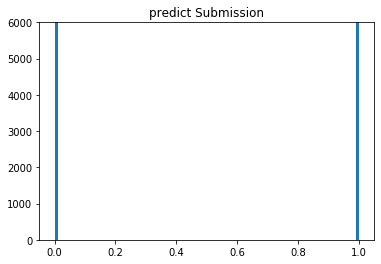

____________________________________________________________________________________________________
Fold 1
  confusion_matrix = 
 [[498987   1361]
 [  1959   4871]]


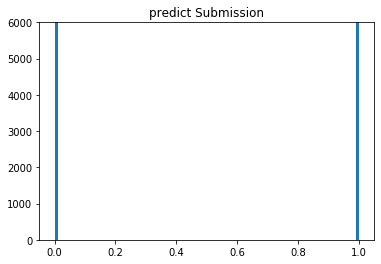

____________________________________________________________________________________________________
Fold 2
  confusion_matrix = 
 [[499220   1593]
 [  1733   4728]]


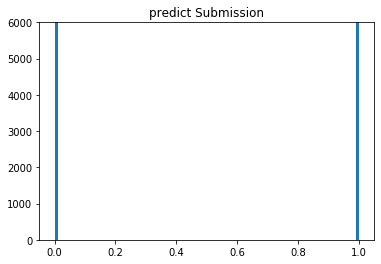

FileNotFoundError: [Errno 2] File b'compare_fold.csv' does not exist: b'compare_fold.csv'

In [37]:
    tStart = time.time()#計時開始   
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X_train.columns
    splits = 3
    oof = np.zeros(len(X_train))
    folds = KFold(n_splits = splits)
    folds = GroupKFold(n_splits=splits)
    ##folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=SEED)
    split_groups = df['locdt'] #group
    #split_groups = df['fraud_ind'] #startifiedkfold   
    f1_avg = 0
    auc_avg = 0
    predictions = np.zeros(len(X_test))
    print(X_train.shape)
    print('train feature ',X_train.columns)
    #for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)): #kfold
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train,groups=split_groups)): #groupkfold and startifiedfold
        print('_'*100)
    
        print("Fold {}".format(fold_))
        
        train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
        valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
        
        
        trn_data = lgb.Dataset(train_df, label=y_train_df)
        val_data = lgb.Dataset(valid_df, label=y_valid_df)
    
        clf = lgb.train(params,
                    trn_data,
                    num_boost_round= 200000,
                    valid_sets = [trn_data, val_data],
                    # categorical_feature=cat_cols,
                    verbose_eval=0,
                    early_stopping_rounds =200 )
        pred = clf.predict(valid_df)
        oof[val_idx] = pred
        #print(pred[0])
        feature_importances['fold_{}'.format(fold_ + 1)] = clf.feature_importance()
    
        #print( "  auc = ", roc_auc_score(y_valid_df, pred) )    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]   
        #print( "  f1 = ", f1_score(y_valid_df, y_pre))
        print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
        auc_avg+= roc_auc_score(y_valid_df, pred)
        f1_avg+=f1_score(y_valid_df, y_pre)
        
        predictions += clf.predict(X_test) / splits
        del trn_data, val_data
        gc.collect()
   
        prediction = [int(item>threshold) for  item in predictions]    
 
        plt.hist(y_pre,bins=100)
        plt.ylim((0,6000))
        plt.title('predict Submission')
        plt.show()
    pred_file_path = 'compare_fold.csv'
    last_oof = np.array(pd.read_csv(pred_file_path))  
    print( "avg  auc = ", auc_avg/ splits )
    print( "avg  f1 = ", f1_avg/ splits)
    print( "last oof  auc = ", roc_auc_score(Y_train, last_oof) )
    print( "oof  auc = ", roc_auc_score(Y_train, oof) )  
    last_oof_threshold = [int(item>0.5) for  item in last_oof] 
    oof_threshold = [int(item>0.5) for  item in oof]
    print( "last oof  f1 = ", f1_score(Y_train, last_oof_threshold))
    print( "oof  f1 = ", f1_score(Y_train, oof_threshold))
    print( "last oof  average_precision = ",average_precision_score(Y_train,last_oof))
    print( "oof  average_precision = ",average_precision_score(Y_train,oof))
    print( "confusion_matrix =")
    print(confusion_matrix(Y_train, oof_threshold))
   
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('Submission')
    plt.show()  
    tEnd = time.time()#計時結束
    #列印結果
    if(roc_auc_score(Y_train, last_oof)<roc_auc_score(Y_train, oof)):
        print("auc improve")
    if(f1_score(Y_train, last_oof_threshold)<f1_score(Y_train, oof_threshold)):
        print("f1 improve")
    if(average_precision_score(Y_train,last_oof)<average_precision_score(Y_train,oof)):
        print('ap improve')
    print ("It cost %f sec" % (tEnd - tStart))#會自動做近位
    

In [ ]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(Y_train,last_oof)
pr,re,t = precision_recall_curve(Y_train,oof)
plt.figure(figsize=(8,8))
plt.plot(l_pr,l_re,color='red',label='last best')
plt.plot(pr,re,color='green',label="now")
plt.legend() 
plt.show()

In [ ]:
print("down h3erer")

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),model1_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:100])
plt.title('Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
# 结果保存
plt.hist(prediction,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show()
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = prediction
sampleSubmission.to_csv('submission_test.csv',index = None)
print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])


In [ ]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':oof})
last_pred.to_csv('compare_fold.csv',index=None)

In [ ]:
seed_num=[42,1121,10,934151515,29595,4462,520,777,1562323,999,915]
for i in seed_num:
    params['seed']= i
    print(params['seed'])
    ####################################
    #######################################################
    # PR 曲线对比
    l_pr,l_re,l_t = precision_recall_curve(Y_train,last_oof)
    pr,re,t = precision_recall_curve(Y_train,oof)
    plt.figure(figsize=(8,8))
    plt.plot(l_pr,l_re,color='red',label='last best')
    plt.plot(pr,re,color='green',label="now")
    plt.legend() 
    plt.show()    
    # 结果保存
    plt.hist(predictions,bins=100)
    plt.ylim((0,5000))
    plt.title('Submission')
    plt.show()
    sampleSubmission = pd.read_csv('submission_test_sample.csv')
    sampleSubmission['fraud_ind'] = prediction 
    sampleSubmission.to_csv('submission_test66941_seed'+str(seed)+'.csv',index = None)
    print('done here')